In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap

import io
from pysam import VariantFile

from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, f1_score

In [2]:
sns.set(style="darkgrid", context="talk", rc={"lines.linewidth": 2})
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set_palette("deep")

In [3]:
tab20 = cm.get_cmap('tab10', 8)
newcmap_list = []
for i in range(4):
    newcmap_list.append(tab20.colors[i])
for i in range(4):
    newcmap_list.append(np.array(list(tab20.colors[i][:-1]) +[0.3]))

newcmap = ListedColormap(newcmap_list, name='newcmap')
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [4]:
df_snv = pd.read_csv('../data/SMURF benchmark/snv-smurf-test20-v7-new5-maxdepth-2.tsv', sep='\t')
df_snv = df_snv[['X.CHROM', 'POS', 'Sample_Name', 'TRUTH', 'FILTER_Mutect2', 'FILTER_Freebayes', 'FILTER_Vardict', 'FILTER_Varscan', 'FILTER_Strelka2', 'predict']]
df_snv['CHROM_POS'] = df_snv['X.CHROM'].astype(str).str.cat(df_snv['POS'].astype(str), sep="_")
df_snv.drop(['X.CHROM', 'POS'], axis=1, inplace=True)
df_snv.columns = ['Sample_Name', 'TRUTH', "mutect2", 'freebayes', 'vardict', 'varscan', 'strelka2', 'smurf', 'CHROM_POS']
df_snv.set_index('CHROM_POS', inplace=True)
print(df_snv.shape)
df_snv.head()

(70783, 8)


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Sample_Name,TRUTH,mutect2,freebayes,vardict,varscan,strelka2,smurf
CHROM_POS,,,,,,,,
1_47492,icgc_cll_tumour,False,False,False,False,True,False,False
1_52058,icgc_cll_tumour,False,False,False,False,True,False,False
1_52058,icgc_cll_N30_tumour,False,False,False,False,True,False,False
1_71992,icgc_cll_tumour,False,False,True,False,False,False,False
1_71992,icgc_cll_N30_tumour,False,False,True,True,False,False,False


In [5]:
df_ind = pd.read_csv('../data/SMURF benchmark/indel-smurf-test20-v7-new5-maxdepth-2.tsv', sep='\t')
#df_ind = df_ind[(df_ind['Sample_Name'] == 'icgc_cll_T20_tumour') | (df_ind['Sample_Name'] == 'icgc_mbl_T20_tumour')]
df_ind = df_ind[['X.CHROM', 'POS', 'Sample_Name', 'TRUTH', 'FILTER_Mutect2', 'FILTER_Freebayes', 'FILTER_Vardict', 'FILTER_Varscan', 'FILTER_Strelka2', 'predict']]
df_ind['CHROM_POS'] = df_ind['X.CHROM'].astype(str).str.cat(df_ind['POS'].astype(str), sep="_")
df_ind.drop(['X.CHROM', 'POS'], axis=1, inplace=True)
df_ind.columns = ['Sample_Name', 'TRUTH', "mutect2", 'freebayes', 'vardict', 'varscan', 'strelka2', 'smurf', 'CHROM_POS']
df_ind.set_index('CHROM_POS', inplace=True)
print(df_ind.shape)
df_ind.head()

(37656, 8)


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Sample_Name,TRUTH,mutect2,freebayes,vardict,varscan,strelka2,smurf
CHROM_POS,,,,,,,,
1_951440,icgc_cll_tumour,False,False,False,False,True,False,False
1_951440,icgc_cll_N30_tumour,False,False,False,False,True,False,False
1_951440,icgc_cll_T20_tumour,False,False,False,False,True,False,False
1_951440,icgc_cll_T40_tumour,False,False,False,False,True,False,False
1_1028417,icgc_cll_tumour,False,False,False,True,True,False,False


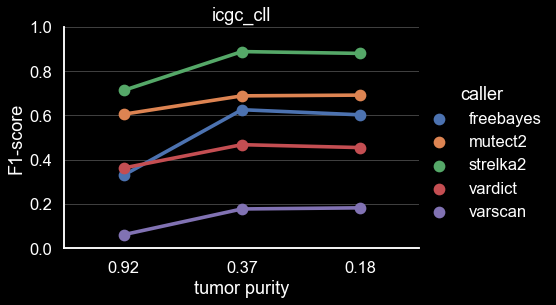

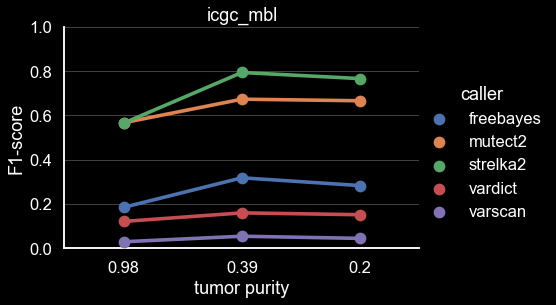

In [10]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll', 'icgc_mbl']
fractions = [0.2, 0.4, 1]
purities = [0.92, 0.98] # source: Weitai

aux_auprc = []
aux_purity = []
aux_caller = []
aux_sample = []
for fraction in fractions:
    for m in methods:
        for si, sample in enumerate(samples):
            if fraction != 1:
                y_true = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour']['TRUTH']
            else:
                y_true = df_snv[df_snv['Sample_Name'] == sample+'_tumour']['TRUTH']
            y_true.index.name = 'CHROM_POS'
            y_true = y_true.astype(bool)
            #baselineAUPRC= len(y_true[y_true == True])/len(y_true)
            if fraction != 1:
                a = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour'][m]
            else:
                a = df_snv[df_snv['Sample_Name'] == sample+'_tumour'][m]
            aux_auprc.append(f1_score(y_true, a.reindex(y_true.index).fillna(False)))
            aux_purity.append(round(fraction*purities[si], 2))
            aux_caller.append(m)
            aux_sample.append(sample)
            #print(sample, m, round(fraction*purities[si], 2), average_precision_score(y_true, a.reindex(y_true.index).fillna(False)))
            #print(a[a==True].shape, y_true[y_true == True].shape)
pd_results['F1-score'] = aux_auprc
pd_results['tumor purity'] = aux_purity
pd_results['caller'] = aux_caller
pd_results['sample'] = aux_sample
    
    
for si, sample in enumerate(samples):
    sns.catplot(x="tumor purity", y="F1-score", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                order=sorted(pd_results[pd_results['sample'] == sample]['tumor purity'].unique(), reverse=True),
                    data=pd_results[pd_results['sample'] == sample])
    #plt.axhline(y = baselineAUPRC, color = 'w', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])
    plt.title(sample)

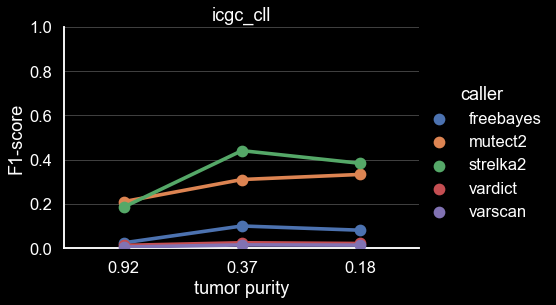

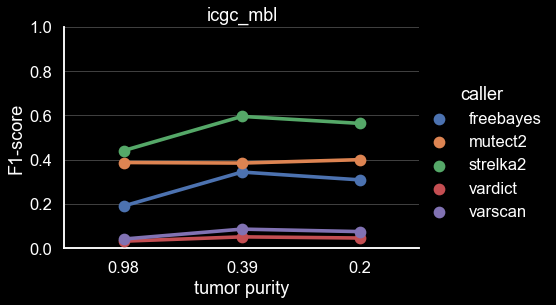

In [11]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll', 'icgc_mbl']
fractions = [0.2, 0.4, 1]
purities = [0.92, 0.98] # source: Weitai

aux_auprc = []
aux_purity = []
aux_caller = []
aux_sample = []
for fraction in fractions:
    for m in methods:
        for si, sample in enumerate(samples):
            if fraction != 1:
                y_true = df_ind[df_ind['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour']['TRUTH']
            else:
                y_true = df_ind[df_ind['Sample_Name'] == sample+'_tumour']['TRUTH']
            y_true.index.name = 'CHROM_POS'
            y_true = y_true.astype(bool)
            #baselineAUPRC= len(y_true[y_true == True])/len(y_true)
            if fraction != 1:
                a = df_ind[df_ind['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour'][m]
            else:
                a = df_ind[df_ind['Sample_Name'] == sample+'_tumour'][m]
            aux_auprc.append(f1_score(y_true, a.reindex(y_true.index).fillna(False)))
            aux_purity.append(round(fraction*purities[si], 2))
            aux_caller.append(m)
            aux_sample.append(sample)
            #print(sample, m, round(fraction*purities[si], 2), average_precision_score(y_true, a.reindex(y_true.index).fillna(False)))
            #print(a[a==True].shape, y_true[y_true == True].shape)
pd_results['F1-score'] = aux_auprc
pd_results['tumor purity'] = aux_purity
pd_results['caller'] = aux_caller
pd_results['sample'] = aux_sample
    
    
for si, sample in enumerate(samples):
    sns.catplot(x="tumor purity", y="F1-score", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                order=sorted(pd_results[pd_results['sample'] == sample]['tumor purity'].unique(), reverse=True),
                    data=pd_results[pd_results['sample'] == sample])
    #plt.axhline(y = baselineAUPRC, color = 'w', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])
    plt.title(sample)

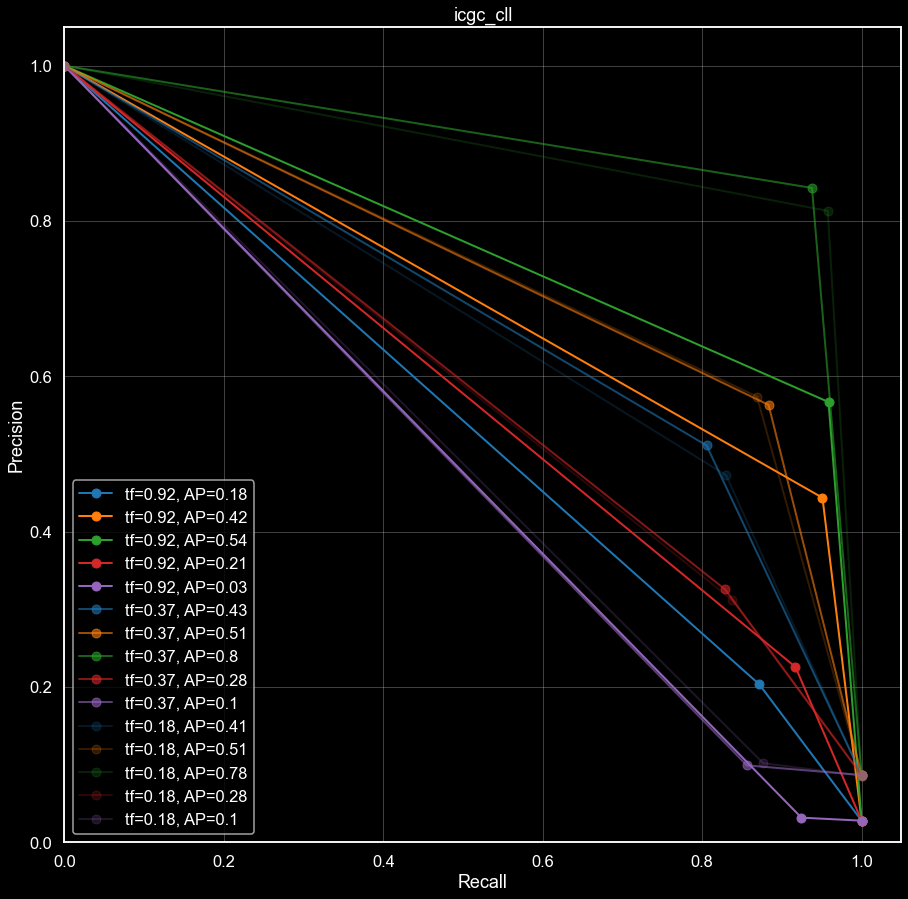

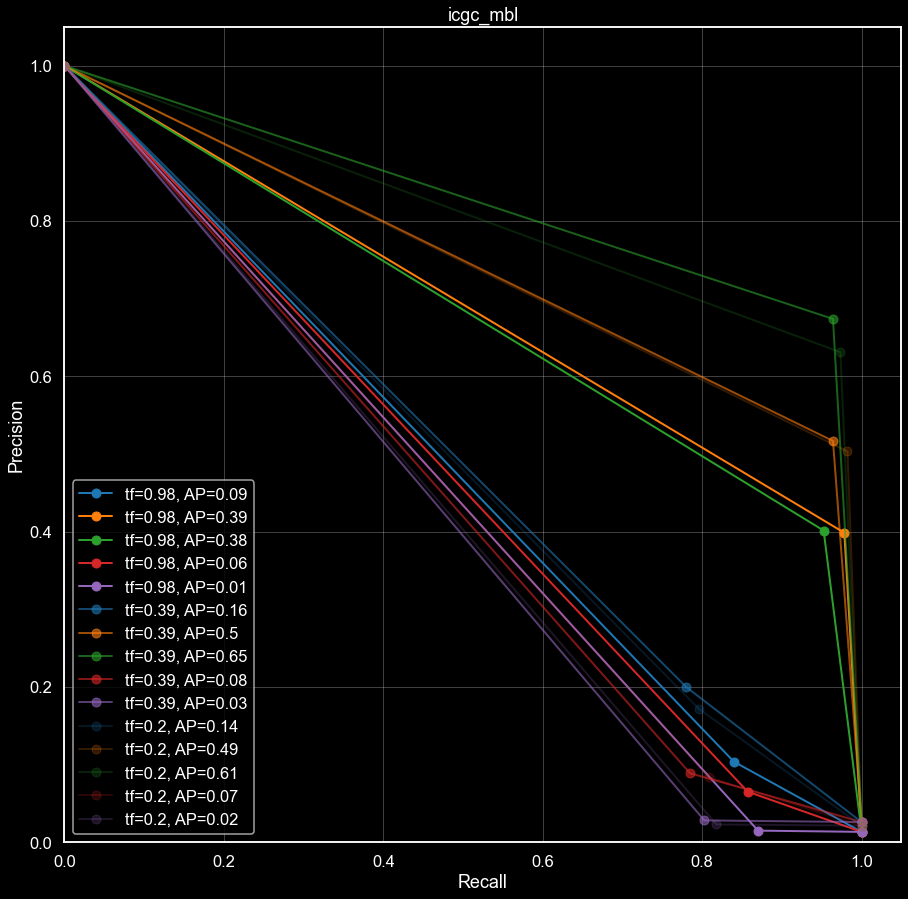

<Figure size 432x288 with 0 Axes>

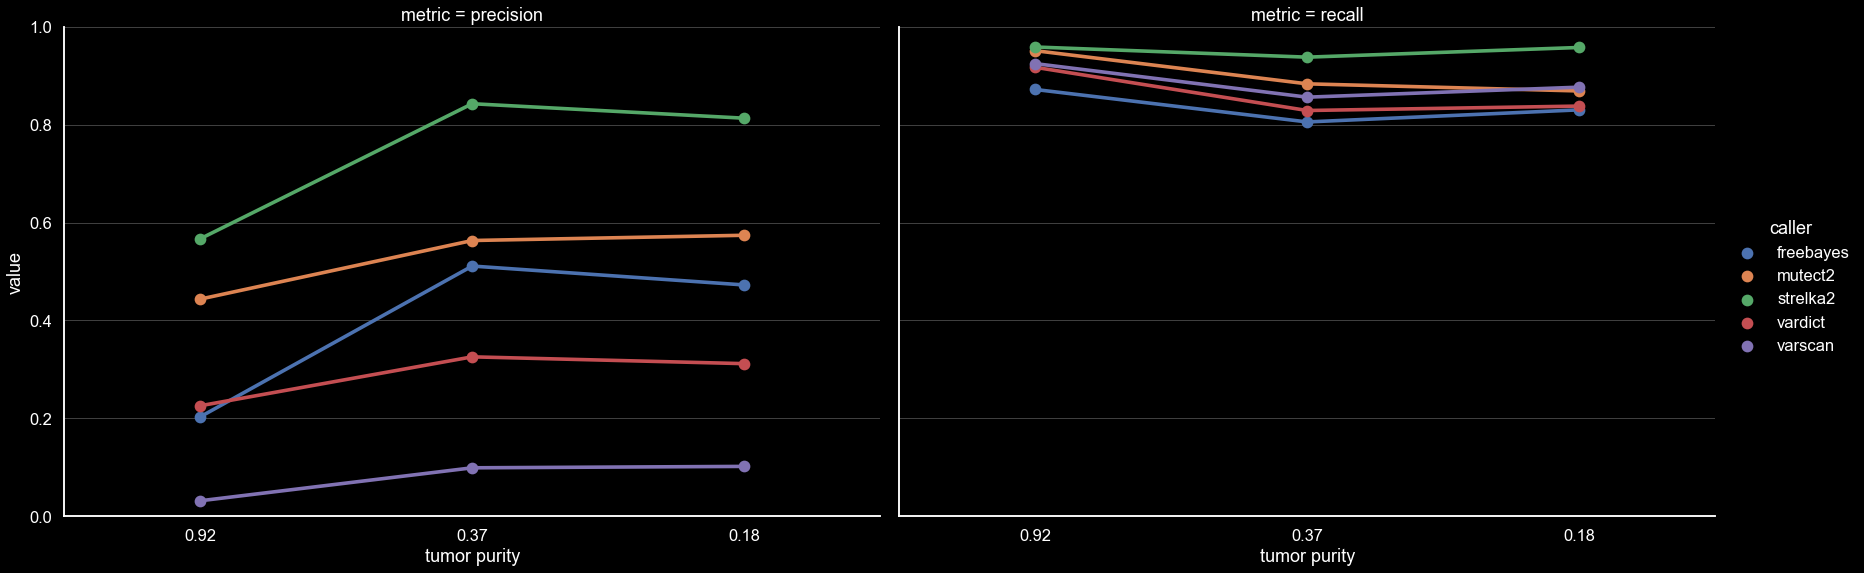

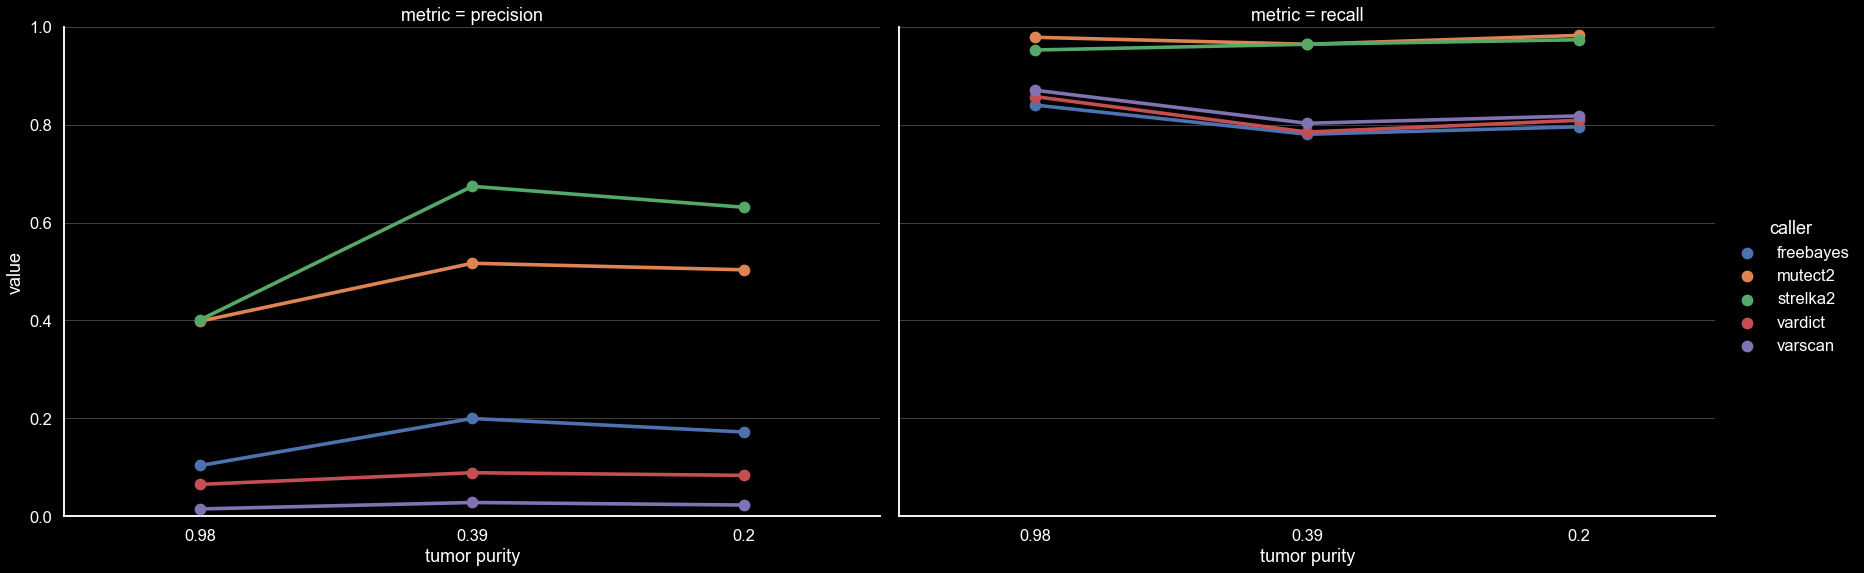

In [82]:
alpha_list = [1, .6, .2]
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll', 'icgc_mbl']
fractions = [1, 0.4, 0.2] #0.2, 0.4, 1]
purities = [0.92, 0.98] # source: Weitai

aux_auprc = []
aux_purity = []
aux_caller = []
aux_sample = []
aux_precision = []
aux_recall = []


for si, sample in enumerate(samples):
    plt.figure(figsize=(15, 15))
    plt.title('Precision-Recall curves')
    for i, fraction in enumerate(fractions):
        for mi, m in enumerate(methods):
                if fraction != 1:
                    y_true = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour']['TRUTH']
                else:
                    y_true = df_snv[df_snv['Sample_Name'] == sample+'_tumour']['TRUTH']
                y_true.index.name = 'CHROM_POS'
                y_true = y_true.astype(bool)
                baselineAUPRC = len(y_true[y_true == True])/len(y_true)
                if fraction != 1:
                    y = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour'][m]
                else:
                    y = df_snv[df_snv['Sample_Name'] == sample+'_tumour'][m]
                precision, recall, _ = precision_recall_curve(y_true, y)
                plt.plot(recall, precision, 'o-', label='tf='+str(round(fraction*purities[si], 2))+ ', AP='+str(round(average_precision_score(y_true, y), 2)),
                              c=color_list[mi], alpha=alpha_list[i])
                aux_auprc.append(average_precision_score(y_true, y.reindex(y_true.index).fillna(False)))
                aux_purity.append(round(fraction*purities[si], 2))
                aux_caller.append(m)
                aux_sample.append(sample)
                aux_precision.append(precision_score(y_true, y))
                aux_recall.append(recall_score(y_true, y))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title(sample)
    plt.legend()
    plt.show()
pd_results['AUPRC'] = aux_auprc
pd_results['tumor purity'] = aux_purity
pd_results['caller'] = aux_caller
pd_results['sample'] = aux_sample
pd_results['precision'] = aux_precision
pd_results['recall'] = aux_recall



plt.figure()
for si, sample in enumerate(samples):
    pd_results_aux = pd.melt(pd_results[pd_results['sample'] == sample], id_vars =['tumor purity', 'caller'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
    sns.catplot(x="tumor purity", y="value", col="metric", hue="caller",  
                    capsize=.2, height=8, aspect=1.5,
                    kind="point", order=sorted(pd_results_aux['tumor purity'].unique(), reverse=True), data=pd_results_aux)
    plt.ylim([0, 1])
    #plt.title(sample)


In [70]:
pd_results_aux

,tumor purity,caller,metric,value
0,0.20,freebayes,precision,0.172115
1,0.20,mutect2,precision,0.503417
2,0.20,strelka2,precision,0.631124
3,0.20,vardict,precision,0.083601
4,0.20,varscan,precision,0.023000
5,0.39,freebayes,precision,0.199770
6,0.39,mutect2,precision,0.516827
7,0.39,strelka2,precision,0.673981
8,0.39,vardict,precision,0.089013
9,0.39,varscan,precision,0.028211


In [68]:
pd_results_aux = pd.melt(pd_results[pd_results['sample'] == sample], id_vars =['tumor purity', 'caller'], value_vars =['precision', 'recall'],
                        var_name='metric', value_name='value')
pd_results_aux

,tumor purity,caller,metric,value
0,0.20,freebayes,precision,0.172115
1,0.20,mutect2,precision,0.503417
2,0.20,strelka2,precision,0.631124
3,0.20,vardict,precision,0.083601
4,0.20,varscan,precision,0.023000
5,0.39,freebayes,precision,0.199770
6,0.39,mutect2,precision,0.516827
7,0.39,strelka2,precision,0.673981
8,0.39,vardict,precision,0.089013
9,0.39,varscan,precision,0.028211


0 icgc_cll freebayes 0.18 0.40681724878064784
(455,) (259,)
0 icgc_mbl freebayes 0.2 0.14130371804223008
(1040,) (225,)
0 icgc_cll mutect2 0.18 0.5098854710223091
(392,) (259,)
0 icgc_mbl mutect2 0.2 0.49484777719336637
(439,) (225,)
0 icgc_cll strelka2 0.18 0.7822221012609604
(305,) (259,)
0 icgc_mbl strelka2 0.2 0.6148647786852637
(347,) (225,)
0 icgc_cll vardict 0.18 0.27512511055725797
(696,) (259,)
0 icgc_mbl vardict 0.2 0.07171510381832075
(2177,) (225,)
0 icgc_cll varscan 0.18 0.09992959489947124
(2227,) (259,)
0 icgc_mbl varscan 0.2 0.022709564371716402
(8000,) (225,)
0 icgc_cll freebayes 0.37 0.42851951293695656
(405,) (257,)
0 icgc_mbl freebayes 0.39 0.16159493491680615
(871,) (223,)
0 icgc_cll mutect2 0.37 0.5076312547396097
(403,) (257,)
0 icgc_mbl mutect2 0.39 0.4992199717317807
(416,) (223,)
0 icgc_cll strelka2 0.37 0.7955870207173342
(286,) (257,)
0 icgc_mbl strelka2 0.39 0.6507364185986604
(319,) (223,)
0 icgc_cll vardict 0.37 0.2847530454429946
(654,) (257,)
0 icgc_mbl

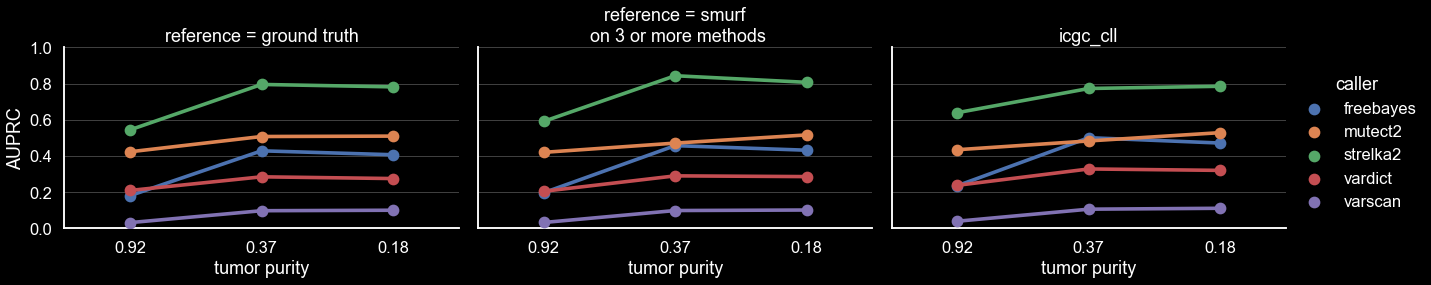

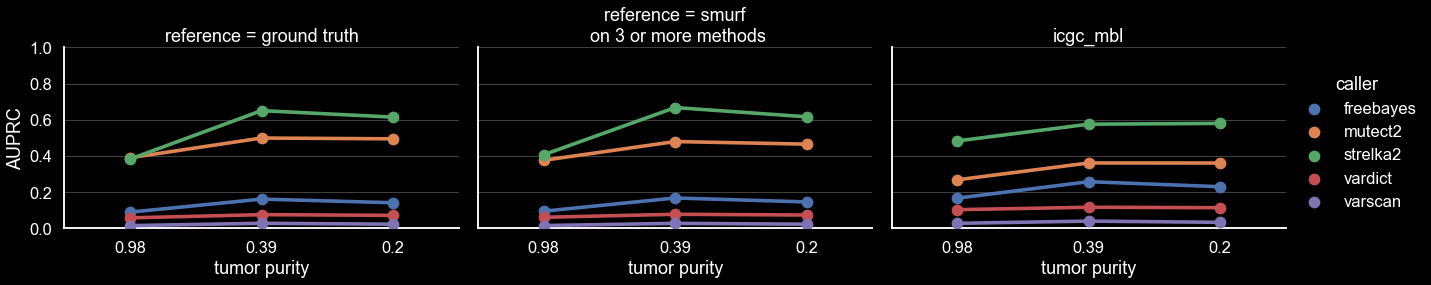

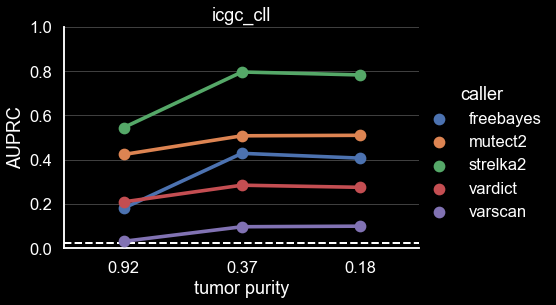

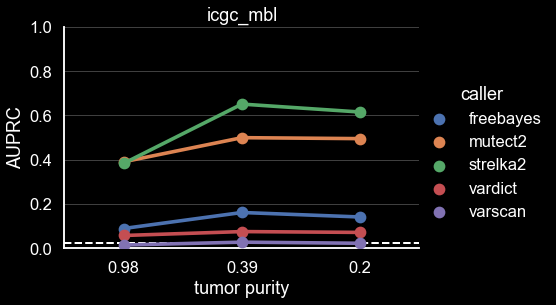

In [41]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll', 'icgc_mbl']
fractions = [0.2, 0.4, 1]
purities = [0.92, 0.98] # source: Weitai

aux_auprc = []
aux_purity = []
aux_caller = []
aux_reference = []
aux_sample = []
for ref in range(3):
    for fraction in fractions:
        for m in methods:
            for si, sample in enumerate(samples):
                if ref == 0: # ground truth
                    if fraction != 1:
                        y_true = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour']['TRUTH']
                    else:
                        y_true = df_snv[df_snv['Sample_Name'] == sample+'_tumour']['TRUTH']
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.astype(bool)
                elif ref == 1: # smurf gt given method at different purities
                    if fraction != 1:
                        y_true = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour']['smurf']
                    else:
                        y_true = df_snv[df_snv['Sample_Name'] == sample+'_tumour']['smurf']
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.astype(bool)
                elif ref == 2: # smurf gt on 3 methods
                    if fraction != 1:
                        y_true = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour'][methods]
                    else:
                        y_true = df_snv[df_snv['Sample_Name'] == sample+'_tumour'][methods]
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.sum(axis=1)
                    y_true[y_true < 3] = 0
                    y_true[y_true != 0 ] = 1
                    y_true = y_true.astype(bool)
                baselineAUPRC= len(y_true[y_true == True])/len(y_true)
                if fraction != 1:
                    a = df_snv[df_snv['Sample_Name'] == sample+'_T'+str(int(100*fraction))+'_tumour'][m]
                else:
                    a = df_snv[df_snv['Sample_Name'] == sample+'_tumour'][m]
                aux_auprc.append(average_precision_score(y_true, a.reindex(y_true.index).fillna(False)))
                aux_purity.append(round(fraction*purities[si], 2))
                aux_caller.append(m)
                aux_sample.append(sample)
                if ref == 0:
                    aux_reference.append('ground truth')
                elif ref == 1:
                    aux_reference.append('smurf\n on 3 or more methods')
                elif ref == 2:
                    aux_reference.append('smurf\n on given method')
                print(ref, sample, m, round(fraction*purities[si], 2), average_precision_score(y_true, a.reindex(y_true.index).fillna(False)))
                print(a[a==True].shape, y_true[y_true == True].shape)
pd_results['AUPRC'] = aux_auprc
pd_results['tumor purity'] = aux_purity
pd_results['caller'] = aux_caller
pd_results['reference'] = aux_reference
pd_results['sample'] = aux_sample


for si, sample in enumerate(samples):
    sns.catplot(x="tumor purity", y="AUPRC", hue="caller",  col='reference',
              capsize=.2, height=4, aspect=1.5, kind="point",
                order=sorted(pd_results[pd_results['sample'] == sample]['tumor purity'].unique(), reverse=True),
                    data=pd_results[pd_results['sample'] == sample])
    plt.axhline(y = 0, color = 'k', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])
    plt.title(sample)
    
    
for si, sample in enumerate(samples):
    sns.catplot(x="tumor purity", y="AUPRC", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                order=sorted(pd_results[pd_results['sample'] == sample]['tumor purity'].unique(), reverse=True),
                    data=pd_results[(pd_results['sample'] == sample) & (pd_results['reference'] == 'ground truth')])
    plt.axhline(y = baselineAUPRC, color = 'w', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])
    plt.title(sample)

# Ground truths

In [22]:
df_snv

,Sample_Name,TRUTH,mutect2,freebayes,vardict,varscan,strelka2,smurf
CHROM_POS,,,,,,,,
1_47492,icgc_cll_tumour,False,False,False,False,True,False,False
1_52058,icgc_cll_tumour,False,False,False,False,True,False,False
1_52058,icgc_cll_N30_tumour,False,False,False,False,True,False,False
1_71992,icgc_cll_tumour,False,False,True,False,False,False,False
1_71992,icgc_cll_N30_tumour,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...
Y_59019171,icgc_mbl_T40_tumour,False,False,False,False,True,False,False
Y_59020799,icgc_mbl_tumour,False,False,False,False,True,False,False
Y_59020799,icgc_mbl_N30_tumour,False,False,False,False,True,False,False


In [20]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll', 'icgc_mbl']

pd_results['AUPRC'] = [average_precision_score(df_snv[df_snv['Sample_Name'] == sample]['TRUTH'], df_snv[df_snv['Sample_Name'] == sample][m])
                       - len(df_snv[df_snv['Sample_Name'] == sample]['TRUTH'][df_snv[df_snv['Sample_Name'] == sample]['TRUTH'] == True])/len(df_snv[df_snv['Sample_Name'] == sample]['TRUTH'])
                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
plt.title('SNV')

IndexError: cannot do a non-empty take from an empty axes.

Text(0.5, 1.0, 'Indels')

<Figure size 432x288 with 0 Axes>

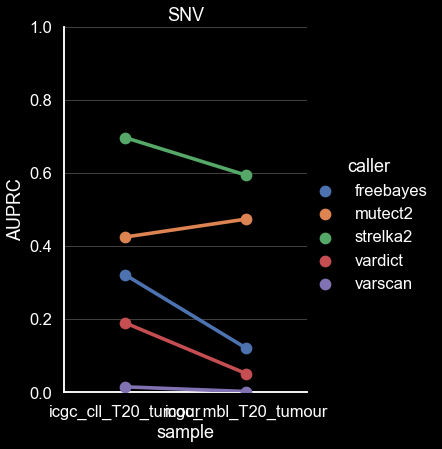

<Figure size 432x288 with 0 Axes>

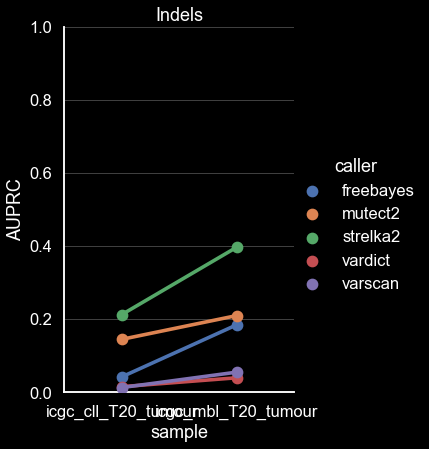

In [7]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']

pd_results['AUPRC'] = [average_precision_score(df_snv[df_snv['Sample_Name'] == sample]['TRUTH'], df_snv[df_snv['Sample_Name'] == sample][m])
                       - len(df_snv[df_snv['Sample_Name'] == sample]['TRUTH'][df_snv[df_snv['Sample_Name'] == sample]['TRUTH'] == True])/len(df_snv[df_snv['Sample_Name'] == sample]['TRUTH'])
                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="sample", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
plt.title('SNV')


pd_results = pd.DataFrame()
pd_results['AUPRC'] = [average_precision_score(df_ind[df_ind['Sample_Name'] == sample]['TRUTH'], df_ind[df_ind['Sample_Name'] == sample][m]) -
                        - len(df_ind[df_ind['Sample_Name'] == sample]['TRUTH'][df_ind[df_ind['Sample_Name'] == sample]['TRUTH'] == True])/len(df_ind[df_ind['Sample_Name'] == sample]['TRUTH'])
                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="sample", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
plt.title('Indels')

# Pseudo ground truth = SMURF output

       AUPRC  tumor burden     caller               sample
0   0.431897           0.2  freebayes  icgc_cll_T20_tumour
1   0.145787           0.2  freebayes  icgc_mbl_T20_tumour
2   0.516376           0.2    mutect2  icgc_cll_T20_tumour
3   0.465434           0.2    mutect2  icgc_mbl_T20_tumour
4   0.807272           0.2   strelka2  icgc_cll_T20_tumour
5   0.616715           0.2   strelka2  icgc_mbl_T20_tumour
6   0.285899           0.2    vardict  icgc_cll_T20_tumour
7   0.073461           0.2    vardict  icgc_mbl_T20_tumour
8   0.101143           0.2    varscan  icgc_cll_T20_tumour
9   0.022630           0.2    varscan  icgc_mbl_T20_tumour
10  0.480198           0.4  freebayes  icgc_cll_T20_tumour
11  0.170103           0.4  freebayes  icgc_mbl_T20_tumour
12  0.528616           0.4    mutect2  icgc_cll_T20_tumour
13  0.504103           0.4    mutect2  icgc_mbl_T20_tumour
14  0.818083           0.4   strelka2  icgc_cll_T20_tumour
15  0.639640           0.4   strelka2  icgc_mbl_T20_tumo

'\npd_results = pd.DataFrame()\naux = []\nfor sample in samples:\n    y_true = df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].index).first()\n    for m in methods:\n        print(sample, m)\n        a = average_precision_score(y_true, df_ind[df_ind[\'Sample_Name\'] == sample][m].reindex(y_true.index).fillna(False))\n        aux.append()\npd_results[\'AUPRC\'] = aux\n#[average_precision_score(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].index).first(),\n#                                               df_ind[df_ind[\'Sample_Name\'] == sample][m].reindex(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smur

<Figure size 432x288 with 0 Axes>

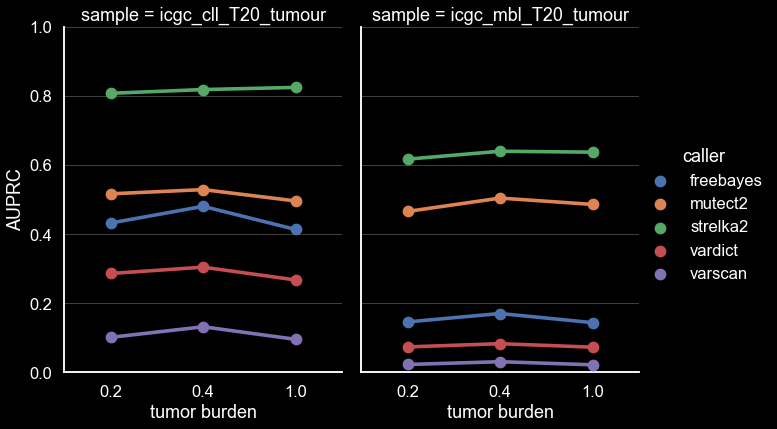

<Figure size 432x288 with 0 Axes>

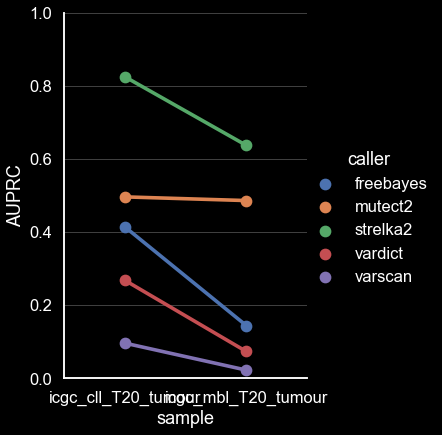

In [9]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']
refs = ['T20_', 'T40_', '']

pd_results['AUPRC'] = [average_precision_score(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour']['smurf'],
                                               df_snv[df_snv['Sample_Name'] == sample][m].reindex(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour']['smurf'].index).fillna(False))
                       for ref in refs for m in methods for sample in samples]
pd_results['tumor burden'] = [ref for ref in [0.2, 0.4, 1] for m in methods for sample in samples]
pd_results['caller'] = [m for ref in refs for m in methods for sample in samples]
pd_results['sample'] = [sample for ref in refs for m in methods for sample in samples]

plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",   col='sample', 
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
#plt.title('SNV')
print(pd_results)

pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']

pd_results['AUPRC'] = [average_precision_score(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+'tumour']['smurf'],
                                               df_snv[df_snv['Sample_Name'] == sample][m].reindex(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+'tumour']['smurf'].index).fillna(False))
                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="sample", y="AUPRC", hue="caller", 
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
#plt.title('SNV')
print(pd_results)

'''
pd_results = pd.DataFrame()
aux = []
for sample in samples:
    y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first()
    for m in methods:
        print(sample, m)
        a = average_precision_score(y_true, df_ind[df_ind['Sample_Name'] == sample][m].reindex(y_true.index).fillna(False))
        aux.append()
pd_results['AUPRC'] = aux
#[average_precision_score(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first(),
#                                               df_ind[df_ind['Sample_Name'] == sample][m].reindex(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first().index).fillna(False))
#                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="sample", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
plt.title('Indels')
'''

# Pseudo

       AUPRC  tumor burden     caller               sample
0   1.000000           0.2  freebayes  icgc_cll_T20_tumour
1   1.000000           0.2  freebayes  icgc_mbl_T20_tumour
2   1.000000           0.2    mutect2  icgc_cll_T20_tumour
3   1.000000           0.2    mutect2  icgc_mbl_T20_tumour
4   1.000000           0.2   strelka2  icgc_cll_T20_tumour
5   1.000000           0.2   strelka2  icgc_mbl_T20_tumour
6   1.000000           0.2    vardict  icgc_cll_T20_tumour
7   1.000000           0.2    vardict  icgc_mbl_T20_tumour
8   1.000000           0.2    varscan  icgc_cll_T20_tumour
9   1.000000           0.2    varscan  icgc_mbl_T20_tumour
10  0.923283           0.4  freebayes  icgc_cll_T20_tumour
11  0.905717           0.4  freebayes  icgc_mbl_T20_tumour
12  0.883256           0.4    mutect2  icgc_cll_T20_tumour
13  0.933115           0.4    mutect2  icgc_mbl_T20_tumour
14  0.950270           0.4   strelka2  icgc_cll_T20_tumour
15  0.922961           0.4   strelka2  icgc_mbl_T20_tumo

'\npd_results = pd.DataFrame()\naux = []\nfor sample in samples:\n    y_true = df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].index).first()\n    for m in methods:\n        print(sample, m)\n        a = average_precision_score(y_true, df_ind[df_ind[\'Sample_Name\'] == sample][m].reindex(y_true.index).fillna(False))\n        aux.append()\npd_results[\'AUPRC\'] = aux\n#[average_precision_score(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].index).first(),\n#                                               df_ind[df_ind[\'Sample_Name\'] == sample][m].reindex(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smur

<Figure size 432x288 with 0 Axes>

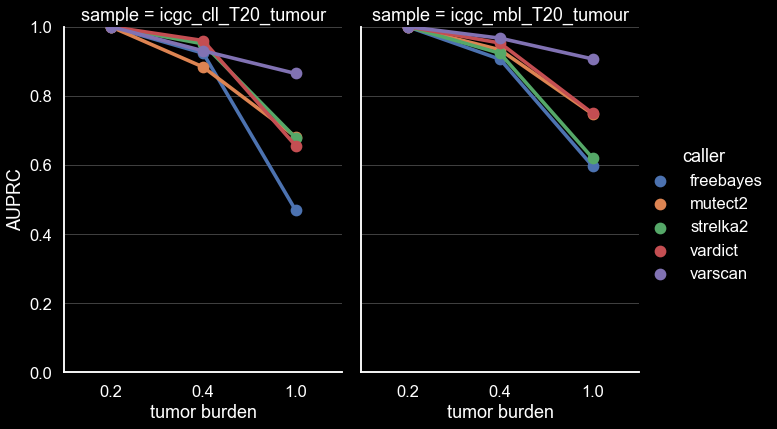

In [10]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']
refs = ['T20_', 'T40_', '']

pd_results['AUPRC'] = [average_precision_score(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour'][m],
                                               df_snv[df_snv['Sample_Name'] == sample][m].reindex(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour'][m].index).fillna(False))
                       for ref in refs for m in methods for sample in samples]
pd_results['tumor burden'] = [ref for ref in [0.2, 0.4, 1] for m in methods for sample in samples]
pd_results['caller'] = [m for ref in refs for m in methods for sample in samples]
pd_results['sample'] = [sample for ref in refs for m in methods for sample in samples]

plt.figure()
sns.catplot(x="tumor burden", y="AUPRC", hue="caller",   col='sample', 
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
#plt.title('SNV')
print(pd_results)

'''
pd_results = pd.DataFrame()
aux = []
for sample in samples:
    y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first()
    for m in methods:
        print(sample, m)
        a = average_precision_score(y_true, df_ind[df_ind['Sample_Name'] == sample][m].reindex(y_true.index).fillna(False))
        aux.append()
pd_results['AUPRC'] = aux
#[average_precision_score(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first(),
#                                               df_ind[df_ind['Sample_Name'] == sample][m].reindex(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first().index).fillna(False))
#                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="sample", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
plt.title('Indels')
'''

'\npd_results = pd.DataFrame()\naux = []\nfor sample in samples:\n    y_true = df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].index).first()\n    for m in methods:\n        print(sample, m)\n        a = average_precision_score(y_true, df_ind[df_ind[\'Sample_Name\'] == sample][m].reindex(y_true.index).fillna(False))\n        aux.append()\npd_results[\'AUPRC\'] = aux\n#[average_precision_score(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].index).first(),\n#                                               df_ind[df_ind[\'Sample_Name\'] == sample][m].reindex(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smurf\']].groupby(df_ind[df_ind[\'Sample_Name\'] == sample.split(\'T\')[0]+\'T40_tumour\'][[\'smur

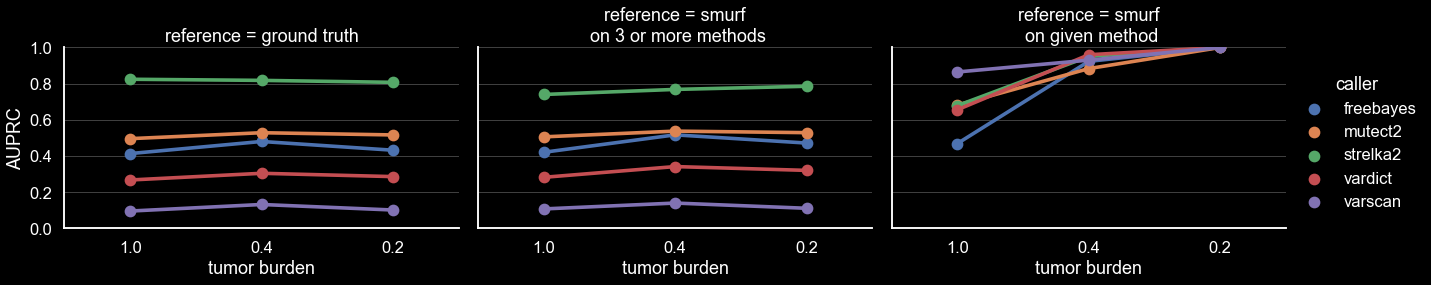

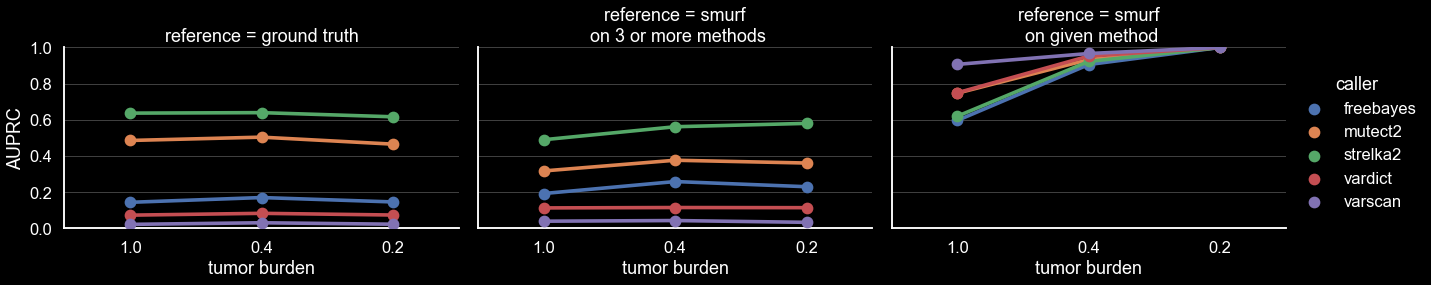

In [11]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']
purities = ['T20_', 'T40_', '']

aux = []
for ref in range(3):
    for purity in purities:
        for m in methods:
            for sample in samples:
                if ref == 0: # ground truth
                    y_true = df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+purity+'tumour']['smurf']
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.astype(bool)
                elif ref == 2: # smurf gt given method at different purities
                    y_true = df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+purity+'tumour'][m]
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.astype(bool)
                elif ref ==1: # smurf gt on 3 methods
                    y_true = df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+purity+'tumour'][methods]
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.sum(axis=1)
                    y_true[y_true < 3] = 0
                    y_true[y_true != 0 ] = 1
                    y_true = y_true.astype(bool)
                aux.append(average_precision_score(y_true, df_snv[df_snv['Sample_Name'] == sample][m].reindex(y_true.index).fillna(False)))
pd_results['AUPRC'] = aux
#pd_results['AUPRC'] = [average_precision_score(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour'][m],
#df_snv[df_snv['Sample_Name'] == sample][m].reindex(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour'][m].index).fillna(False))
pd_results['tumor burden'] = [purity for ref in range(3) for purity in [0.2, 0.4, 1] for m in methods for sample in samples]
pd_results['caller'] = [m for ref in range(3) for purity in purities for m in methods for sample in samples]
pd_results['sample'] = [sample  for ref in range(3) for purity in purities for m in methods for sample in samples]
pd_results['reference'] = [ref for ref in ['ground truth','smurf\n on 3 or more methods',  'smurf\n on given method'] for purity in purities for m in methods for sample in samples]

for si, sample in enumerate(samples):
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  col='reference',
              capsize=.2, height=4, aspect=1.5, kind="point",
                order=sorted(np.unique(pd_results['tumor burden'].values), reverse=True),
                    data=pd_results[pd_results['sample'] == sample])
    plt.ylim([0, 1])

'''
pd_results = pd.DataFrame()
aux = []
for sample in samples:
    y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first()
    for m in methods:
        print(sample, m)
        a = average_precision_score(y_true, df_ind[df_ind['Sample_Name'] == sample][m].reindex(y_true.index).fillna(False))
        aux.append()
pd_results['AUPRC'] = aux
#[average_precision_score(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first(),
#                                               df_ind[df_ind['Sample_Name'] == sample][m].reindex(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first().index).fillna(False))
#                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="sample", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
plt.title('Indels')
'''

3
0.004354587869362364
0 freebayes T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name='CHROM_POS')
4
0.017241379310344827
0 freebayes T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name='CHROM_POS')
3
0.004354587869362364
0 mutect2 T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name='CHROM_POS')
4
0.017241379310344827
0 mutect2 T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name='CHROM_POS')
3
0.004354587869362364
0 strelka2 T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name='CHROM_POS')
4
0.017241379310344827
0 strelka2 T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name='CHROM_POS')
3
0.004354587869362364
0 vardict T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name='CHROM_POS')
4
0.017241379310344827
0 vardict T20_
Index([], dtype='object', name='CHROM_POS')
Index([], dtype='object', name

NameError: name 'bas' is not defined

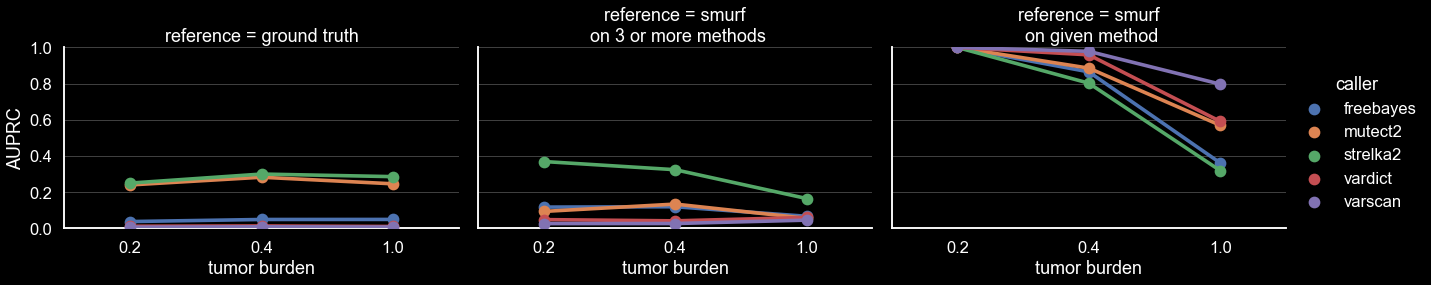

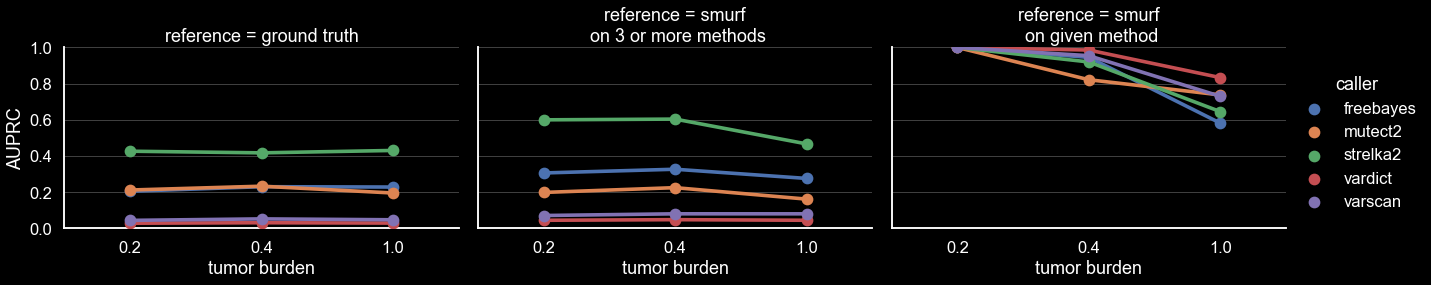

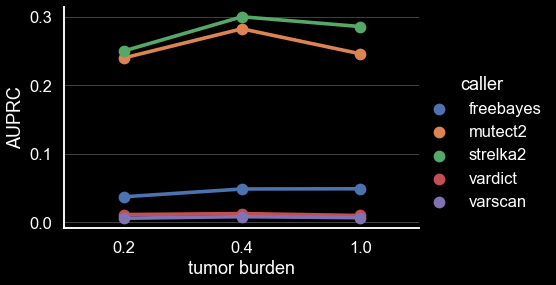

In [12]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']
purities = ['T20_', 'T40_', '']

aux = []
for ref in range(3):
    for purity in purities:
        for m in methods:
            for sample in samples:
                if ref == 0: # ground truth
                    y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+purity+'tumour']['smurf']
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.astype(bool)
                elif ref == 2: # smurf gt given method at different purities
                    y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+purity+'tumour'][m]
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.astype(bool)
                elif ref ==1: # smurf gt on 3 methods
                    y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+purity+'tumour'][methods]
                    y_true.index.name = 'CHROM_POS'
                    y_true = y_true.sum(axis=1)
                    y_true[y_true < 3] = 0
                    y_true[y_true != 0 ] = 1
                    y_true = y_true.astype(bool)
                print(sum(y_true.index.duplicated()))
                y_true = y_true[~y_true.index.duplicated(keep='first')]
                baselineAUPRC= len(y_true[y_true == True])/len(y_true)
                print(baselineAUPRC)
                print(ref, m, purity)
                print(y_true.index[y_true.index.duplicated()])
                a = df_ind[df_ind['Sample_Name'] == sample][m]
                a = a[~a.index.duplicated(keep='first')]
                print(a.index[a.index.duplicated()])
                aux.append(average_precision_score(y_true, a.reindex(y_true.index).fillna(False)))
pd_results['AUPRC'] = aux
#pd_results['AUPRC'] = [average_precision_score(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour'][m],
#df_snv[df_snv['Sample_Name'] == sample][m].reindex(df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+ref+'tumour'][m].index).fillna(False))
pd_results['tumor burden'] = [purity for ref in range(3) for purity in [0.2, 0.4, 1] for m in methods for sample in samples]
pd_results['caller'] = [m for ref in range(3) for purity in purities for m in methods for sample in samples]
pd_results['sample'] = [sample  for ref in range(3) for purity in purities for m in methods for sample in samples]
pd_results['reference'] = [ref for ref in ['ground truth','smurf\n on 3 or more methods',  'smurf\n on given method'] for purity in purities for m in methods for sample in samples]

for si, sample in enumerate(samples):
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",  col='reference',
              capsize=.2, height=4, aspect=1.5, kind="point",
                    data=pd_results[pd_results['sample'] == sample])
    plt.axhline(y = 0, color = 'k', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])
    
    
for si, sample in enumerate(samples):
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                    data=pd_results[(pd_results['sample'] == sample) & (pd_results['reference'] == 'ground truth')])
    plt.axhline(y = bas, color = 'k', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])

'''
pd_results = pd.DataFrame()
aux = []
for sample in samples:
    y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first()
    for m in methods:
        print(sample, m)
        a = average_precision_score(y_true, df_ind[df_ind['Sample_Name'] == sample][m].reindex(y_true.index).fillna(False))
        aux.append()
pd_results['AUPRC'] = aux
#[average_precision_score(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first(),
#                                               df_ind[df_ind['Sample_Name'] == sample][m].reindex(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].groupby(df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+'T40_tumour'][['smurf']].index).first().index).fillna(False))
#                       for m in methods for sample in samples]
pd_results['tumor burden'] = 0.2
pd_results['caller'] = [m for m in methods for sample in samples]
pd_results['sample'] = [sample for m in methods for sample in samples]

plt.figure()
sns.catplot(x="sample", y="AUPRC", hue="caller",  
                capsize=.2, height=6, aspect=.75, kind="point", data=pd_results)
plt.ylim([0, 1])
plt.title('Indels')
'''

0
0.08573320092684542
0
0.08659029649595687
0
0.02785368929997898
0
0.021406145942346112
0
0.02603315433107635
0
0.013423208786100297


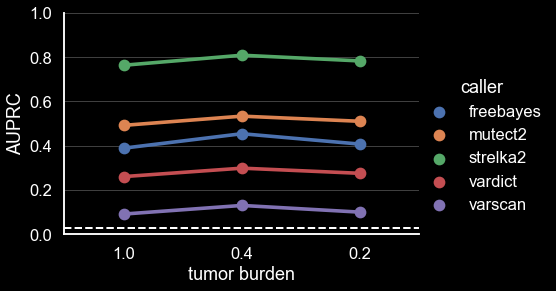

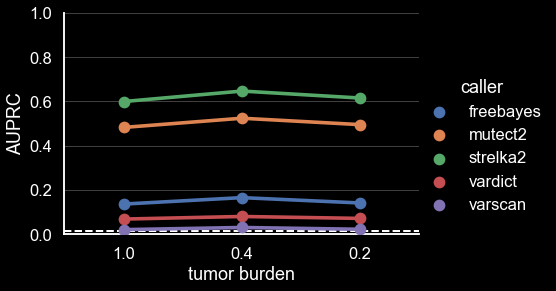

In [13]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']
purities = ['T20_', 'T40_', '']

aux = []
baselineAUPRC_dict = {}

for sample in samples:
    for purity in purities:
        y_true = df_snv[df_snv['Sample_Name'] == sample.split('T')[0]+purity+'tumour']['TRUTH']
        y_true.index.name = 'CHROM_POS'
        y_true = y_true.astype(bool)
        print(sum(y_true.index.duplicated()))
        y_true = y_true[~y_true.index.duplicated(keep='first')]
        baselineAUPRC= len(y_true[y_true == True])/len(y_true)
        print(baselineAUPRC)
        baselineAUPRC_dict[sample] = baselineAUPRC
        for m in methods:
            a = df_snv[df_snv['Sample_Name'] == sample][m]
            a = a[~a.index.duplicated(keep='first')]
            aux.append(average_precision_score(y_true, a.reindex(y_true.index).fillna(False)))
pd_results['AUPRC'] = aux
pd_results['tumor burden'] = [purity for sample in samples for purity in [0.2, 0.4, 1] for m in methods]
pd_results['caller'] = [m for sample in samples for purity in purities for m in methods ]
pd_results['sample'] = [sample for sample in samples for purity in purities for m in methods ]

for si, sample in enumerate(samples):
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                order = sorted(np.unique(pd_results['tumor burden'].values), reverse=True),
                    data=pd_results[(pd_results['sample'] == sample)])
    plt.axhline(y = baselineAUPRC_dict[sample], color = 'w', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])

3
0.0052877138413685845
2
0.005632745024408562
2
0.0023021931418877985
4
0.01605231866825208
3
0.018125854993160054
2
0.009429020429544265


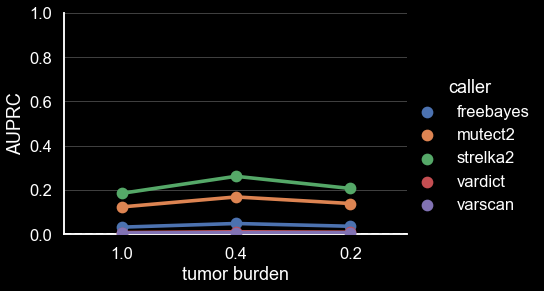

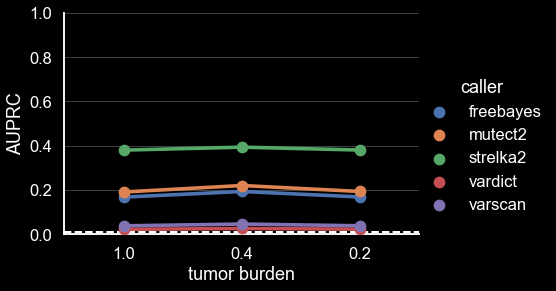

In [14]:
pd_results = pd.DataFrame()
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
samples = ['icgc_cll_T20_tumour', 'icgc_mbl_T20_tumour']
purities = ['T20_', 'T40_', '']

aux = []
baselineAUPRC_dict = {}

for sample in samples:
    for purity in purities:
        y_true = df_ind[df_ind['Sample_Name'] == sample.split('T')[0]+purity+'tumour']['TRUTH']
        y_true.index.name = 'CHROM_POS'
        y_true = y_true.astype(bool)
        print(sum(y_true.index.duplicated()))
        y_true = y_true[~y_true.index.duplicated(keep='first')]
        baselineAUPRC= len(y_true[y_true == True])/len(y_true)
        print(baselineAUPRC)
        baselineAUPRC_dict[sample] = baselineAUPRC
        for m in methods:
            a = df_ind[df_ind['Sample_Name'] == sample][m]
            a = a[~a.index.duplicated(keep='first')]
            aux.append(average_precision_score(y_true, a.reindex(y_true.index).fillna(False)))
pd_results['AUPRC'] = aux
pd_results['tumor burden'] = [purity for sample in samples for purity in [0.2, 0.4, 1] for m in methods]
pd_results['caller'] = [m for sample in samples for purity in purities for m in methods ]
pd_results['sample'] = [sample for sample in samples for purity in purities for m in methods ]

for si, sample in enumerate(samples):
    sns.catplot(x="tumor burden", y="AUPRC", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                order = sorted(np.unique(pd_results['tumor burden'].values), reverse=True),
                    data=pd_results[(pd_results['sample'] == sample)])
    plt.axhline(y = baselineAUPRC_dict[sample], color = 'w', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])